# image and annotation processing
This notebook is part of the project _Automated plant stage labelling of herbarium samples in the family *Brassicaceae*_ made at [Propulsion Academy Zurich](https://propulsion.academy/?gclid=Cj0KCQiAwf39BRCCARIsALXWETyIhnHT7bA3VYXXOC415brejc6qYXnX7kEpqJmmJ5d5kAcYgoiLhI4aAmPxEALw_wcB) in collaboration with [ETH Library](https://library.ethz.ch/en/).

This notebook allows to preprocess images and annotations to prepare them for model training using mask_RCNN. It includes the following steps:

- resize images
- scale annotations appropriately
- remove segments that have too few points

The same results can be obtained by launching the `pre-process_images.py` script from command line. see README for more details

In [1]:
import os
import json
import shutil
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt


## Data and settings
set the folder paths below to load annotations and images

In [1]:
# set folder paths
orig_anno_fldr_path = os.path.join("..","data","raw")
img_src_fldr_path = os.path.join('..','data','raw')
img_output_fldr_path = os.path.join('..','data','output')

NameError: name 'os' is not defined

# Functions

In [2]:
def calc_resize_with_apect(size, max_dimension):
    """
    calculate new image size that preserves the aspect ratio but does not exceed the max dimension
    size: tuple, current image size
    max_dimension: int, dimension not to exceed
    """
    w = size[0]
    h = size[1]

    # if min(size) > min_dimension:
    
    max_orig_dim = max(size)
    
    new_w = (w / max_orig_dim) * max_dimension
    new_h = (h / max_orig_dim) * max_dimension
        
    new_size = (int(new_w), int(new_h))

    return new_size


def resize_image(pil_image, max_dimension, return_ratio=False):
    """
    resize a pil image to have the maximum dimension given on oneside while preserving aspect ratio
    pil_image: PIL.Image, image to resize
    max_dimension: int, max size
    return_ratio: bool, return the original image size divided by new image size
    
    """
    
    orig_size = pil_image.size
    new_size = calc_resize_with_apect(orig_size, max_dimension)
    pil_image = pil_image.resize(new_size, resample = Image.ANTIALIAS)
    
    if return_ratio:
        resized_ratio = orig_size[0] / new_size[0]
        return pil_image, resized_ratio
    
    return pil_image

In [3]:
def pad_image_to_square(pil_image, constant_values=0):
        """
        convert a rectangular image to a square by padding the smaller side with a constant value
        pil_image: PIL.Image, 
        constant_values: int, 0-255 value to pad image with 
        """
        
        im_array = np.array(pil_image)
        
        h = im_array.shape[0]
        w = im_array.shape[1]

        h_padding = max(0, (w - h))
        w_padding = max(0, (h - w))

        h_padding_bottom = np.ceil(h_padding).astype(int)
        w_padding_bottom = np.ceil(w_padding).astype(int)

        paddings = np.array([[0, h_padding_bottom],
                                [0, w_padding_bottom],
                                [0,0]])

        im_array = np.pad(im_array, paddings, constant_values=constant_values)

        return Image.fromarray(im_array)

In [28]:
def resize_pad_and_save_image(input_fpath, img_output_fldr_path, max_dimension=1024):
    
    im = Image.open(input_fpath)
    # this paramater can be returned by the resize image function, 
    # in order to also scale the annotations
    resized_ratio = None
    im, resized_ratio = resize_image(im, max_dimension, return_ratio=True)
    im_s = pad_image_to_square(im)
    # save resized image
    fname = os.path.basename(input_fpath)
    output_fpath = os.path.join(img_output_fldr_path, fname)
    im_s.save(output_fpath)

    if resized_ratio:
        return resized_ratio

In [30]:

def process_images_and_annotations(img_src_fldr_path, img_output_fldr_path, orig_anno_dict, split='train', max_img_dimension=1024):
    
    missing_files = []
    ratios_dict = {}
    new_annotations = []

    #make sure output folder exists
    img_output_fldr_path = os.path.join(img_output_fldr_path, split)
    if not os.path.exists(img_output_fldr_path):
        os.makedirs(img_output_fldr_path)
        print('created directory: {}'.format(img_output_fldr_path))

    # Process Images
    print('outputting images to: {}'.format(img_output_fldr_path))
    for record in orig_anno_dict['images']:

        fname = record['file_name']
        src_path = os.path.join(img_src_fldr_path, fname)

        if os.path.exists(src_path):
            resized_ratio = resize_pad_and_save_image(src_path, img_output_fldr_path, max_dimension=max_img_dimension)
            # in case all pictures are not the same size, keep a dict of image id and resized ratios, to resize the annotations later
            ratios_dict[record['id']] = resized_ratio

        else:
            missing_files.append(record['id'])
            print('no src file: ', record['file_name'])

    # Process annotations
    for orig_anno in orig_anno_dict['annotations']:

        if orig_anno['image_id'] in missing_files:
            continue

        image_id = orig_anno['image_id']
        new_anno = orig_anno

        #scale segmentation
        try:
            resize_ratio = ratios_dict[image_id]
        except:
            print("annotation was skipped for image_id: {}".format(image_id))
            next

        scaled_segmentations = []
        for seg in orig_anno['segmentation']:
            # remove segments with less than 6 points as this can't make a mask
            if len(seg) < 6:
                print('less than 6 points in segment for annotation: ', orig_anno['id'], ' image_id: ', image_id)
                continue

            scaled_segmentation = np.array(seg) / resize_ratio
            scaled_segmentation = np.round(scaled_segmentation, decimals=1).tolist()
            scaled_segmentations.append(scaled_segmentation)

        new_anno['segmentation'] = scaled_segmentations
        # scale bounding box
        new_anno['bbox'] = [np.round(pnt/resize_ratio,1) for pnt in orig_anno['bbox']]
        # scale area
        new_anno['area'] = np.round((orig_anno['area']/resize_ratio**2))
        #images_sizes
        new_anno['width'] = max_img_dimension
        new_anno['height'] = max_img_dimension

        new_annotations.append(new_anno)

    new_image_records = []

    for img_record in orig_anno_dict['images']:
        if img_record['id'] in missing_files:
            continue
        img_record['path'] = os.path.join(img_output_fldr_path, img_record['file_name'])
        img_record['width'] = max_img_dimension
        img_record['height'] = max_img_dimension
        new_image_records.append(img_record)


    ## save new annotation json file
    new_dict = {}
    new_dict['categories'] = orig_anno_dict['categories']
    new_dict['annotations'] = new_annotations
    new_dict['images'] = new_image_records

    output_fpath = os.path.join(img_output_fldr_path,split+'.json')
    with open(output_fpath,'w') as f:
        json.dump(new_dict,f)

    return new_dict

In [31]:
def load_annotations_dict(orig_anno_fldr_path, split='train'):
    
    with open(fpath, 'r') as f:
        orig_anno_dict = json.load(f)
        
    return orig_anno_dict

# Main

In [32]:
# load original annotations
split='train'
orig_anno_dict = load_annotations_dict(orig_anno_fldr_path, split=split)
# process images and annotatons
new_anno_dict_train = process_images_and_annotations(img_src_fldr_path, 
                               img_output_fldr_path, 
                               orig_anno_dict, 
                               split=split, 
                               max_img_dimension=1024)

outputting images to: ../data/processed/cas_square/train
no src file:  CAS0087567.jpg
no src file:  CAS0087564.jpg


In [33]:
# load original annotations
split='test'
orig_anno_dict = load_annotations_dict(orig_anno_fldr_path, split=split)
# process images and annotatons
new_anno_dict_test = process_images_and_annotations(img_src_fldr_path, 
                               img_output_fldr_path, 
                               orig_anno_dict, 
                               split=split, 
                               max_img_dimension=1024)

outputting images to: ../data/processed/cas_square/test
no src file:  CAS0087582.jpg
less than 6 points in segment for annotation:  38842  image_id:  691



### check output

In [36]:
img_rec = new_anno_dict_train['images'][0]
img = plt.imread(img_rec['path'])

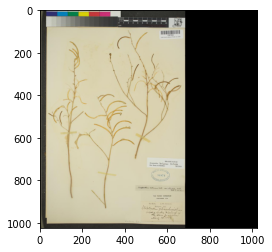

In [37]:
plt.imshow(img)
plt.show()